<a href="https://colab.research.google.com/github/rbgt/Bayesian_Data_Analysis/blob/main/%5BSwift%5DMCMC_MetropolisHastings_from_scratch/Swift_MCMC_Metropolis_Hasting_from_scratch_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import Foundation
import Darwin
import TensorFlow
import Python
// This cell is here to display the plots in a Jupyter Notebook.
// Do not copy it into another environment.
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

2020-11-24 10:54:16.841837: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Use `print()` to show values.


We'll use the Python libraries for plotting our mathematical functions

In [2]:
let shell = Python.import("subprocess").getoutput
let plt = Python.import("matplotlib.pyplot")

In [3]:
shell("/swift/toolchain/usr/bin/swift --version")

Use `print()` to show values.


Helper structs and funcs for statistical distributions and common operations on Arrays

In [4]:
public struct Common {
    private static let pi = Double.pi
    
    /**
     Calculate `n!` for values of `n` that conform to the BinaryInteger
     protocol.  Returns `nil` if `n` is less than zero.
     */
    public static func factorial<T: BinaryInteger>(_ n: T) -> Int? {
        if n < 0 {
            return nil
        }
        return Int(tgamma(Double(n+1)))
    }

    /**
     Calculate `n!` for values of `n` that conform to the BinaryFloatingPoint
     protocol.  Uses the gamma function to "fill in" values of `n` that are
     not integers.  Returns `nil` if `n` is less than zero.
     */
    public static func factorial<T: BinaryFloatingPoint>(_ n: T) -> Double? {
        if n < 0 {
            return nil
        }
        return Double(tgamma(Double(n+1)))
    }

    /**
     Calculate n-choose-k for values of `n` and `k` that conform to the BinaryInteger
     protocol.
     */
    public static func choose<T: BinaryInteger>(n: T, k: T) -> Int {
        return Int(tgamma(Double(n + 1)))/Int(tgamma(Double(k + 1))*tgamma(Double(n - k + 1)))
    }

    /**
     Calculate n-choose-k for values of `n` that conform to the BinaryFloatingPoint
     protocol and values of `k` that conform to the BinaryInteger protocol.
     */
    public static func choose<N: BinaryFloatingPoint, K: BinaryInteger>(n: N, k: K) -> Double {
        return Double(tgamma(Double(n + 1)))/Double(tgamma(Double(k + 1))*tgamma(Double(Double(n) - Double(k) + 1)))
    }

    
    /**
     Calculates the mean of an array of values for types that satisfy the
     BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data: Array of values
     
     - Returns:
        The mean of the array of values or `nil` if the array was empty.
     */
    public static func mean<T: BinaryInteger>(_ data: [T]) -> Double? {
        if data.count == 0 {
            return nil
        }
        return Double(data.reduce(0, +))/Double(data.count)
    }

    /**
     Calculates the mean of an array of values for types that satisfy the
     BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data: Array of values
     
     - Returns:
     The mean of the array of values or `nil` if the array was empty.
     */
    public static func mean<T : BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.count == 0 {
            return nil
        }
        return Double(data.reduce(0, +))/Double(data.count)
    }

    
    /**
     Calculates the unbiased sample variance for an array for types that satisfy
     the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
        The unbiased sample variance or `nil` if `data` contains fewer than two
        values.
     */
    public static func variance<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.count < 2 {
            return nil
        }
        
        guard let m = mean(data) else {
            return nil // This shouldn't ever occur
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count-1)
    }
    
    /**
     Calculates the unbiased sample standard deviation for an array of values
     for types that satisfy the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
        The sample unbiased standard deviation or `nil` if `data` contains fewer
        than two values.
     */
    public static func sd<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        guard let v = variance(data) else {
            return nil
        }
        return sqrt(v)
    }
    
    /**
     Calculates the unbiased sample standard deviation for an array of values
     for types that satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
     The sample unbiased standard deviation or `nil` if `data` contains fewer
     than two values.
     */
    public static func sd<T: BinaryInteger>(_ data: [T]) -> Double? {
        guard let v = variance(data) else {
            return nil
        }
        return sqrt(v)
    }

    /**
     Calculates the population variance for an array of values for types that
     satisfy the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func pvariance<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.count < 1 {
            return nil
        }
        guard let m = mean(data) else {
            return nil // This shouldn't ever occur
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count)
    }

    /**
     Calculates the unbiased sample variance for an array of values for types
     that satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Sample of values.  Note that this should contain at least two values.
     
     - Returns:
     The unbiased sample variance or `nil` if `data` contains fewer than two
     values.
     */
    public static func variance<T: BinaryInteger>(_ data: [T]) -> Double? {
        if data.count < 2 {
            return nil
        }
        
        guard let m = mean(data) else {
            return nil // This shouldn't ever occur
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count-1)
    }

    /**
     Calculates the population variance for an array of values for types that
     satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func pvariance<T: BinaryInteger>(_ data: [T]) -> Double? {
        guard let m = mean(data) else {
            return nil
        }
        var total = 0.0
        for i in 0..<data.count {
            total += pow(Double(data[i]) - m,2)
        }
        return total/Double(data.count)
    }
    
    /**
     Calculates the median of an array of values for types that
     satisfy the BinaryFloatingPoint protocol (e.g Float, Double).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func median<T: BinaryFloatingPoint>(_ data: [T]) -> Double? {
        if data.isEmpty {
            return nil
        }
        let sorted_data = data.sorted()
        if data.count % 2 == 1 {
            return Double(sorted_data[Int(floor(Double(data.count)/2))])
        }
        else {
            return Double(sorted_data[data.count/2]+sorted_data[(data.count/2)-1])/2
        }
    }
    
    /**
     Calculates the median of an array of values for types that
     satisfy the BinaryInteger protocol (e.g Int, Int32).
     
     - Parameters:
        - data:
        Values of population.  Note that this should contain at least one value.
     
     - Returns:
     The population variance or `nil` if `data` contains fewer than one value.
     */
    public static func median<T: BinaryInteger>(_ data: [T]) -> Double? {
        if data.isEmpty {
            return nil
        }
        let sorted_data = data.sorted()
        if data.count % 2 == 1 {
            return Double(sorted_data[Int(floor(Double(data.count)/2))])
        }
        else {
            return Double(sorted_data[data.count/2]+sorted_data[(data.count/2)-1])/2
        }
    }

   
    public static func erfinv(_ y: Double) -> Double {
        let center = 0.7
        let a = [ 0.886226899, -1.645349621,  0.914624893, -0.140543331]
        let b = [-2.118377725,  1.442710462, -0.329097515,  0.012229801]
        let c = [-1.970840454, -1.624906493,  3.429567803,  1.641345311]
        let d = [ 3.543889200,  1.637067800]
        if abs(y) <= center {
            let z = pow(y,2)
            let num = (((a[3]*z + a[2])*z + a[1])*z) + a[0]
            let den = ((((b[3]*z + b[2])*z + b[1])*z + b[0])*z + 1.0)
            var x = y*num/den
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            return x
        }

        else if abs(y) > center && abs(y) < 1.0 {
            let z = pow(-log((1.0-abs(y))/2),0.5)
            let num = ((c[3]*z + c[2])*z + c[1])*z + c[0]
            let den = (d[1]*z + d[0])*z + 1
            // should use the sign public static function instead of pow(pow(y,2),0.5)
            var x = y/pow(pow(y,2),0.5)*num/den
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            x = x - (erf(x) - y)/(2.0/sqrt(pi)*exp(-x*x))
            return x
        }

        else if abs(y) == 1 {
            return y*Double(Int.max)
        }

        else {
            // this should throw an error instead
            return Double.nan
        }
    }

    public static func lsr(_ points: [[Double]]) -> [Double] {
        var total_x = 0.0
        var total_xy = 0.0
        var total_y = 0.0
        var total_x2 = 0.0
        for i in 0..<points.count {
            total_x += points[i][0]
            total_y += points[i][1]
            total_xy += points[i][0]*points[i][1]
            total_x2 += pow(points[i][0], 2)
        }
        let N = Double(points.count)
        let b = (N*total_xy - total_x*total_y)/(N*total_x2 - pow(total_x, 2))
        let a = (total_y - b*total_x)/N
        return [a, b]
    }

}

In [5]:
public protocol ContinuousDistribution {
    func quantile(_ p: Double) -> Double
}

extension ContinuousDistribution {
    /**
     Single discrete random value using a user-provided random number generator
     
     - Parameters:
       - using: A random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random<T: RandomNumberGenerator>(using generator: inout T) -> Double {
        let x = Double.random(in: 0.0...1.0,
                              using: &generator)
        return quantile(x)
    }

    /**
     Single discrete random value using the system random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random() -> Double {
        var rng = SystemRandomNumberGenerator()
        return random(using: &rng)
    }
    
    
    /**
     Array of discrete random values
     - Parameter n: number of values to produce
     - Complexity: O(n)
     */
    public func random(_ n: Int) -> [Double] {
        var results: [Double] = []
        for _ in 0..<n {
            results.append(random())
        }
        return results
    }

}

/**
 Protocol for discrete distributions.
 
 Defines the `quantile()` method that must be implemented.
 */
public protocol DiscreteDistribution {
    func quantile(_ p: Double) -> Int
}

extension DiscreteDistribution {
    /**
     Single discrete random value using a user-provided random number generator
     
     - Parameters:
       - using: A random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random<T: RandomNumberGenerator>(using generator: inout T) -> Int {
        let x = Double.random(in: 0.0...1.0,
                              using: &generator)
        return quantile(x)
    }
    
    /**
     Single discrete random value using the system random number generator
     
     - Returns:
     A random number from the distribution represented by the instance
     */
    public func random() -> Int {
        var rng = SystemRandomNumberGenerator()
        return random(using: &rng)
    }
    
    /**
     Array of discrete random values
     - Parameter n: number of values to produce
     - Complexity: O(n)
     */
    public func random(_ n: Int) -> [Int] {
        var results: [Int] = []
        for _ in 0..<n {
            results.append(random())
        }
        return results
    }

}

In [6]:
public class Bernoulli: DiscreteDistribution {
    var p: Double
    
    public init(p: Double) {
        self.p = p
    }
    
    public convenience init?<T: BinaryInteger>(data: [T]) {
        guard let m = Common.mean(data) else {
            return nil
        }
        self.init(p: m)
    }
    
    public func pmf(_ k: Int) -> Double {
        if k == 1 {
            return self.p
        }
        if k == 0 {
            return 1 - self.p
        }
        return -1
    }
    
    public func cdf(_ k: Int) -> Double {
        if k < 0 {
            return 0
        }

        if k < 1 {
            return 1 - self.p
        }
        if k >= 1 {
            return 1
        }
        return -1
    }
    
    public func quantile(_ p: Double) -> Int {
        if p < 0 {
            return -1
        }
        else if p < 1 - self.p {
            return 0
        }
        else if p <= 1 {
            return 1
        }
        return -1
    }
}

In [7]:
public class Normal: ContinuousDistribution {
    // mean and variance
    var m: Double
    var v: Double

    public init(m: Double, v: Double) {
        self.m = m
        self.v = v
    }
    
    public convenience init(mean: Double, sd: Double) {
        // This contructor takes the mean and standard deviation, which is the more
        // common parameterisation of a normal distribution.
        let variance = pow(sd, 2)
        self.init(m: mean, v: variance)
    }

    public convenience init?(data: [Double]) {
        // this calculates the mean twice, since variance()
        // uses the mean and calls mean()
        guard let v = Common.variance(data) else {
            return nil
        }
        guard let m = Common.mean(data) else {
            return nil // This shouldn't ever occur
        }
        self.init(m: m, v: v)
    }

    public func pdf(_ x: Double) -> Double {
        let pi = Common.pi
        return (1/pow(self.v * 2 * pi,0.5))*exp(-pow(x-self.m,2)/(2*self.v))
    }

    public func cdf(_ x: Double) -> Double {
        return (1 + erf((x-self.m)/pow(2*self.v,0.5)))/2
    }

    public func quantile(_ p: Double) -> Double {
        return self.m + pow(self.v*2,0.5)*Common.erfinv(2*p - 1)
    }
}

public class Uniform: ContinuousDistribution {
    // a and b are endpoints, that is
    // values will be distributed uniformly between points a and b
    var a: Double
    var b: Double

    public init(a: Double, b: Double) {
        self.a = a
        self.b = b
    }

    public func pdf(_ x: Double) -> Double {
        if x>a && x<b {
            return 1/(b-a)
        }
        return 0
    }

    public func cdf(_ x: Double) -> Double {
        if x<a {
            return 0
        }
        else if x<b {
            return (x-a)/(b-a)
        }
        else if x>=b {
            return 1
        }
        return 0
    }

    public func quantile(_ p: Double) -> Double {
        if p>=0 && p<=1{
            return p*(b-a)+a
        }
        return Double.nan
    }
}

In [8]:
//Helper function to convert arrays to tensor
public func arrayToTensor(_ array:Array<Double>) -> Tensor<Double> {
    var new_tensor:Tensor<Double> = .init(array)
    return new_tensor
}
var array_test:Array<Double> = [1,3,4]
print(arrayToTensor(array_test), type(of: arrayToTensor(array_test)))

[1.0, 3.0, 4.0] Tensor<Double>


MCMC from scratch : Metropolis-Hastings algorithm

In [9]:
let mod1 = Normal(mean: 10, sd: 3).random

let population = mod1(30000)

In [10]:
let index_shuffled = (0..<30000).shuffled()[0..<1000]
var observations:Array<Double> = []

for i in index_shuffled {
    observations.append(population[i])
}

In [11]:
print(index_shuffled)

[7429, 2828, 11640, 27556, 18975, 17879, 12053, 4102, 1505, 16176, 25225, 16333, 24782, 2992, 14285, 9271, 14582, 27421, 12816, 11025, 25994, 2312, 467, 22573, 26264, 14828, 26453, 4401, 3679, 19478, 24246, 26899, 20223, 21931, 11184, 11015, 17022, 23740, 3309, 4587, 14826, 5385, 5942, 5370, 27743, 12882, 11003, 20783, 15382, 20645, 16659, 26134, 24035, 13068, 19657, 8071, 22867, 11277, 17534, 11239, 17062, 480, 10462, 3925, 16819, 5751, 16988, 29451, 12673, 22452, 10714, 21267, 21331, 10267, 20786, 29928, 26723, 16910, 776, 19137, 23619, 17310, 1927, 16472, 27914, 9509, 18399, 16038, 28164, 22436, 5793, 4114, 18502, 26377, 10685, 3280, 16025, 5325, 11979, 17652, 29146, 21124, 22935, 18564, 1231, 20395, 14161, 13354, 14680, 3526, 19952, 2179, 23549, 22814, 10573, 20481, 11104, 7050, 2499, 801, 1890, 2385, 11626, 15464, 18512, 8452, 23300, 21263, 28373, 7298, 13786, 6129, 11644, 6984, 12271, 22625, 5212, 9829, 18797, 296, 22872, 23557, 20823, 28729, 28542, 17301, 20881, 26815, 9143, 181

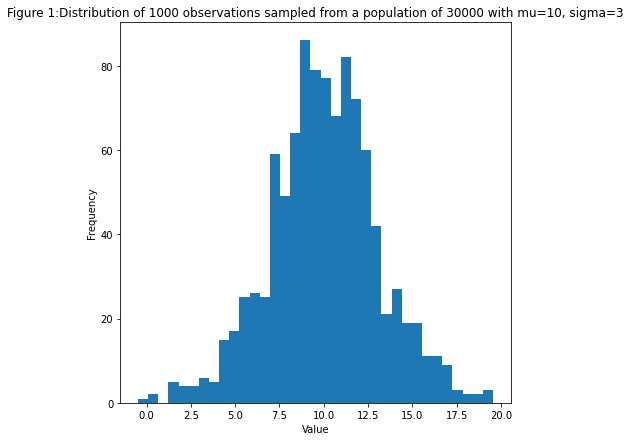

Use `print()` to show values.


In [12]:
let fig = plt.figure(figsize:[7,7])
let ax = fig.add_subplot(1,1,1)
ax.hist(observations,bins:35)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1:Distribution of 1000 observations sampled from a population of 30000 with mu=10, sigma=3")
plt.show()

In [14]:
let mean_observation:Tensor<Double> = .init(observations)
let mu_obs:Double = Double(mean_observation.mean())!
let sd_obs:Double = Double(mean_observation.standardDeviation())!
let var_obs:Double = Double(mean_observation.variance())!
print(mu_obs, type(of: mu_obs), type(of: mean_observation), sd_obs, var_obs)

10.048812266894009 Double Tensor<Double> 3.0607905430699067 9.368438748546174


Metropolis-hasting implementation

In [15]:
func transition_model(_ x:Array<Double>) -> Array<Double> {
    var ret_arr:Array<Double> = []
    ret_arr.append(x[0])
    ret_arr.append(Normal(mean: x[1], sd: 0.5).random(1)[0])
    return ret_arr
}

func prior(_ x:Array<Double>) -> Int {
    //x[0] = mu, x[1]=sigma (new or current)
    //returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    //returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    //It makes the new sigma infinitely unlikely.
    if (x[1] <= 0) {
        return 0
    }
    return 1
}

func manual_log_like_normal(_ x:Array<Double>,_ data:Array<Double>) -> Double {
    //x[0]=mu, x[1]=sigma (new or current)
    //data = the observation
    let fact_1:Double = -log(x[1] * pow(2 * Double.pi, 0.5))
    let fact_2:Array<Double> = data.map({pow($0 - x[0],2) / (2 * pow(x[1],2))})
    var substract:Array<Double> = []    
    for i in 0..<fact_2.count {
        substract.append(fact_1 - fact_2[i])
    }
    return (substract).reduce(0,+)
}

func acceptance(_ x:Double, _ x_new:Double) -> Bool{
    if x_new > x {
        return true
    }
    else {
        let accept:Double = Uniform(a: 0, b: 1).random(1)[0]
        //Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        //less likely x_new are less likely to be accepted
        return (accept < (exp(x_new - x)))
    }
}

func metropolis_hastings(_ likelihood_computer:(_ x:Array<Double>,_ data:Array<Double>) -> Double,_ prior:(_ x:Array<Double>) -> Int, _ transition_model:(_ x:Array<Double>) -> Array<Double>, _ param_init:Array<Double>,_ iterations:Int,_ data:Array<Double>,_ acceptance_rule:(_ x:Double, _ x_new:Double) -> Bool) -> ((Array<Double>,Array<Double>), (Array<Double>,Array<Double>)){
    var x:Array<Double> = param_init
    var accepted:(Array<Double>,Array<Double>) = ([],[])
    var rejected:(Array<Double>,Array<Double>) = ([],[])
    for i in 0..<iterations {
        var x_new:Array<Double> = transition_model(x)
        var x_lik:Double = likelihood_computer(x, data)
        var x_new_lik:Double = likelihood_computer(x_new, data)
        if acceptance_rule( x_lik + log(Double(prior(x))), x_new_lik + log(Double(prior(x_new))) ) {
            x = x_new
            //Accepted
            accepted.0.append(x_new[0])
            accepted.1.append(x_new[1])
        }
        else {
            //Rejected
            rejected.0.append(x_new[0])
            rejected.1.append(x_new[1])
        }
    }
    return (accepted, rejected)
}   

In [16]:
var accepted_rejected:((Array<Double>,Array<Double>),(Array<Double>,Array<Double>)) = (([],[]),([],[]))

accepted_rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observations,acceptance)

In [17]:
print(accepted_rejected.0.1[accepted_rejected.0.1.count - 10..<accepted_rejected.0.1.count])

[3.1345387012595998, 3.1531907176784384, 2.953381352160761, 2.942047287166266, 3.2320593617524422, 2.9593368612279325, 3.1054816200060067, 3.104403868922551, 3.0894577977848514, 2.992056873474725]


In [18]:
print(accepted_rejected.0.1.count, accepted_rejected.1.1.count)

8465 41535


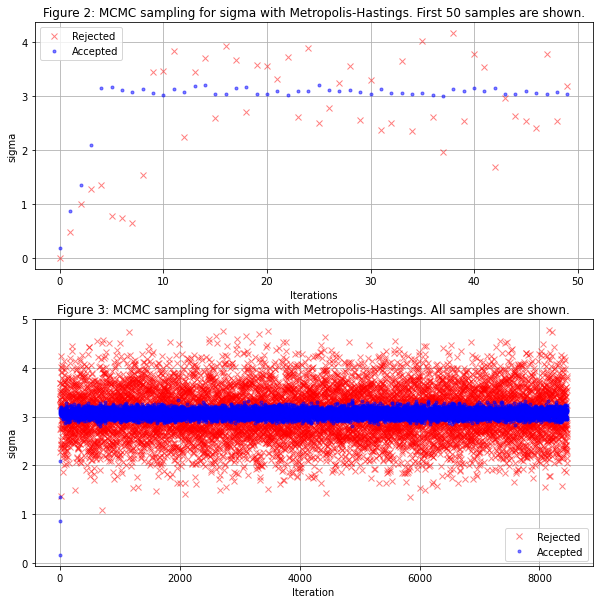

Use `print()` to show values.


In [19]:
let fig = plt.figure(figsize:[10,10])
let ax = fig.add_subplot(2,1,1)

ax.plot((0..<50).map({$0}), Array<Double>(accepted_rejected.1.1[0..<50]), "rx",label:"Rejected",alpha:0.5)
ax.plot((0..<50).map({$0}), Array<Double>(accepted_rejected.0.1[0..<50]), "b.",label:"Accepted", alpha:0.5)
ax.set_xlabel("Iterations")
ax.set_ylabel("sigma")
ax.set_title("Figure 2: MCMC sampling for sigma with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()


let ax2 = fig.add_subplot(2,1,2)
var to_show = accepted_rejected.0.1.count
var borne_max = accepted_rejected.1.1.count
var borne_min = borne_max - to_show

ax2.plot((0..<accepted_rejected.0.1.count).map({$0}), Array<Double>(accepted_rejected.1.1[borne_min..<borne_max]),"rx", label:"Rejected",alpha:0.5)
ax2.plot((0..<accepted_rejected.0.1.count).map({$0}), Array<Double>(accepted_rejected.0.1),"b.", label:"Accepted",alpha:0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("sigma")
ax2.set_title("Figure 3: MCMC sampling for sigma with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()
plt.show()

In [20]:
let show = Int(Double(accepted_rejected.0.0.count) * 0.75)
print(accepted_rejected.0.1.count - show)

2117


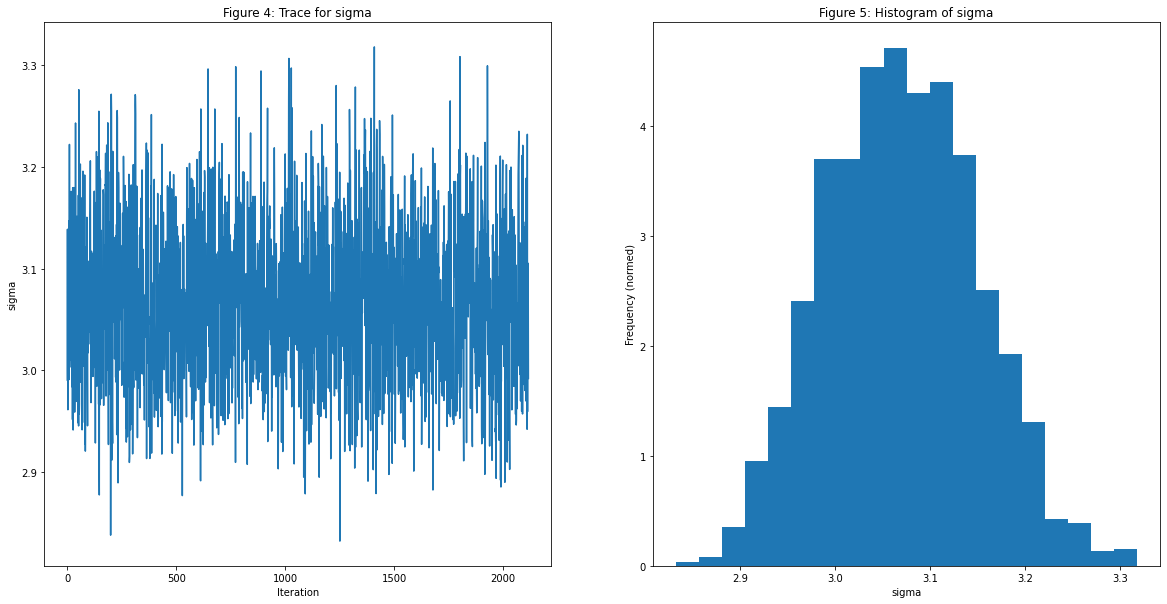

Use `print()` to show values.


In [21]:
let show = Int(Double(accepted_rejected.0.0.count) * 0.75)

let fig = plt.figure(figsize:[20,10])
var ax = fig.add_subplot(1,2,1)
ax.plot((0..<(accepted_rejected.0.1.count - show)).map({$0}),Array<Double>(accepted_rejected.0.1[show..<accepted_rejected.0.1.count]))
ax.set_title("Figure 4: Trace for sigma")
ax.set_ylabel("sigma")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(Array<Double>(accepted_rejected.0.1[show..<accepted_rejected.0.1.count]), bins:20, density:true)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("sigma")
ax.set_title("Figure 5: Histogram of sigma")

plt.show()

In [22]:
let mu = Tensor<Double>(accepted_rejected.0.0[show..<accepted_rejected.0.0.count]).mean()
let sigma = Tensor<Double>(accepted_rejected.0.1[show..<accepted_rejected.0.1.count]).mean()
print(mu,sigma, type(of: Double(mu)))

10.048812266893979 3.0698891995932103 Optional<Double>


In [23]:
func model_lambda(_ t:Int,_ mu:Double,_ sigma:Double) -> Array<Double> {
    let ret_val:Array<Double> = Normal(mean: mu, sd: sigma).random(t)
    return ret_val
}

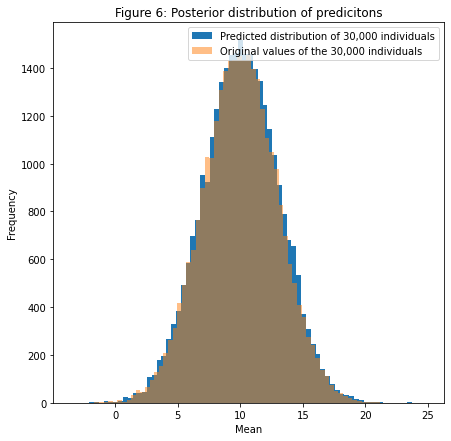

Use `print()` to show values.


In [24]:
let observation_gen = model_lambda(population.count, Double(mu)!, Double(sigma)!)
let fig = plt.figure(figsize:[7,7])
var ax = fig.add_subplot(1,1,1)
ax.hist(observation_gen, bins:70, label:"Predicted distribution of 30,000 individuals")
ax.hist(population, bins:70, alpha:0.5, label:"Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()
plt.show()

=========================================END====================================